In [1]:
import os.path as osp
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import torchvision
from datetime import datetime
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import time
import PIL
import kornia

from model_utils import*
from mymodelzoo import*
from transforms import*

from torchvision.transforms import transforms
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
    print(torch.cuda.get_device_name(0))

GeForce GTX 1080 Ti


In [2]:
SEED = 888

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
class TargetClassSet(Dataset):
    
    def __init__(self, data_dir):
        self.data, self.targets = torch.load(data_dir)
#         self.data = self.data[:20]
#         self.targets = self.targets[:20]
        
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        return img, target
    
    def __len__(self):
        return self.data.size(0)

In [4]:
trainset = TargetClassSet("./data/training.pt")
trainloader = DataLoader(trainset, batch_size=1, num_workers=10)

In [5]:
testset = TargetClassSet("./data/test.pt")
testloader = DataLoader(testset, batch_size=1, num_workers=10)

In [ ]:
# # Generating training/test set of the targeted class
# targeted_label = 8

# images_train, labels_train = [], []
# for images, labels in trainloader:
#     if labels.item() == targeted_label:
#         images_train.append(images)
#         labels_train.append(labels)
# train_pt = (torch.cat(images_train), torch.cat(labels_train))
# torch.save(train_pt, "./data/training.pt")

# images_test, labels_test = [], []
# for images, labels in testloader:
#     if labels.item() == targeted_label:
#         images_test.append(images)
#         labels_test.append(labels)
# test_pt = (torch.cat(images_test), torch.cat(labels_test))
# torch.save(test_pt, "./data/test.pt")

In [6]:
model = LeNet().to(device)
#Load a checkpoint
ckp_out_root = './models/lenet'
ckp_dir = osp.join(ckp_out_root, "checkpoint.pth.tar")
if osp.isfile(ckp_dir):
    ckp = torch.load(ckp_dir)
    print(f"=> Loading checkpoint from {ckp_dir}")
    ckp_epoch = ckp["epoch"]
    best_test_acc = ckp["best_acc"]
    model.load_state_dict(ckp["state_dict"])
    print(f"=> Loaded checkpoint '{ckp_dir}' (epoch {ckp_epoch})")
    print(f"=> Best test acc. {best_test_acc}%")
else:
    print(f"No checkpoint found in {ckp_dir}")

=> Loading checkpoint from ./models/lenet/checkpoint.pth.tar
=> Loaded checkpoint './models/lenet/checkpoint.pth.tar' (epoch 2)
=> Best test acc. 99.0%


### Random transformation

In [35]:
def get_clipped_loss(loss_fn, min_val, max_val):
    def clipped_loss(logits, labels):
        loss = loss_fn(logits, labels)
        return torch.clamp(loss, min_val, max_val)
    return clipped_loss

def get_random_gaussian_pt(max_sigma=0.1):
    def add_gaussian_noise(x):
        mean = 0
        sigma = np.random.uniform(0, max_sigma)
        gauss = sigma*torch.randn_like(x).to(x.device)
        x_t = torch.clamp(x + gauss, 0., 1.)
        return x_t
    return add_gaussian_noise

def get_random_contrast_pt(min_alpha=0.9, max_alpha=1.4):
    def contrast_random(x):
        alpha = np.random.uniform(min_alpha, max_alpha)
#         alpha = torch.rand((x.size(0), 1, 1, 1)).to(x.device)
#         alpha = (alpha - max_alpha) / (max_alpha-min_alpha)
        x_t = torch.clamp(x*alpha, 0., 1.)
        return x_t
    return contrast_random

def get_random_brightness_pt(min_beta=-0.05, max_beta=0.05):
    def brightness_random(x):
        beta = np.random.uniform(min_beta, max_beta)
#         beta = torch.rand((x.size(0), 1, 1, 1)).to(x.device)
#         beta = (beta - max_beta) / (max_beta-min_beta)
        x_t = torch.clamp(x+beta, 0., 1.)
        return x_t
    return brightness_random

def get_random_rotate_kornia(max_deg=22.5):
    def rotate_random(x):
        rotate = kornia.augmentation.RandomRotation(max_deg, return_transform=False)
        return rotate(x)
    return rotate_random

In [36]:
T = [get_random_gaussian_pt(max_sigma=0.1),
     get_random_rotate_kornia(max_deg=22.5),
     get_random_contrast_pt(min_alpha=0.9, max_alpha=1.4),
     get_random_brightness_pt(min_beta=-0.05, max_beta=0.05)]

random_transform = RandomTransform(T)

### Sanity check for random transformation

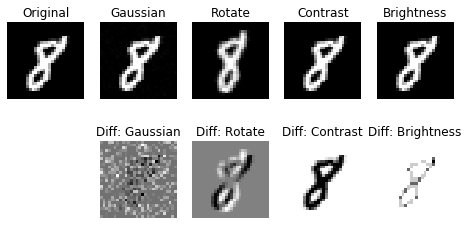

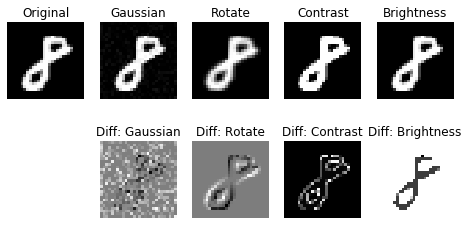

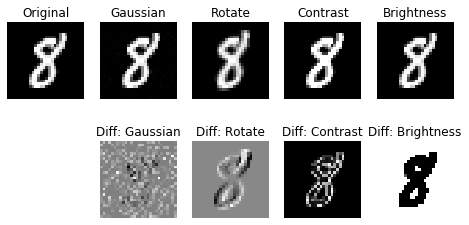

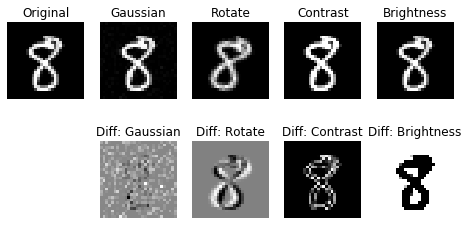

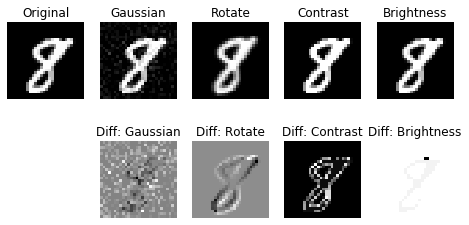

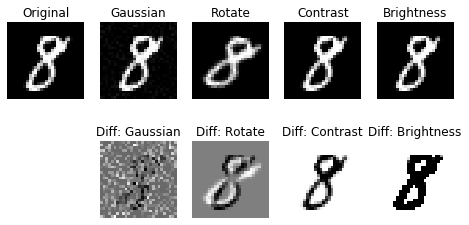

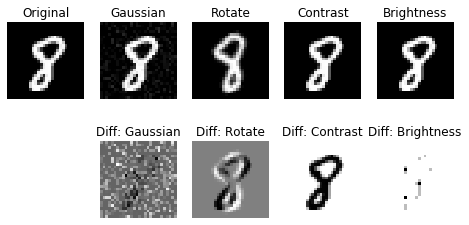

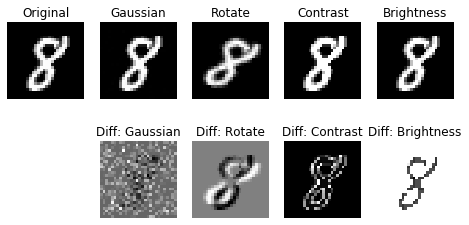

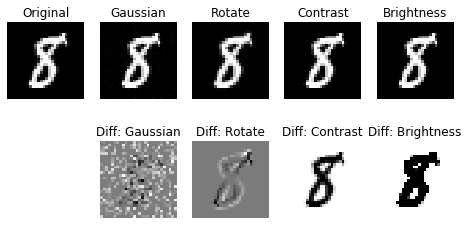

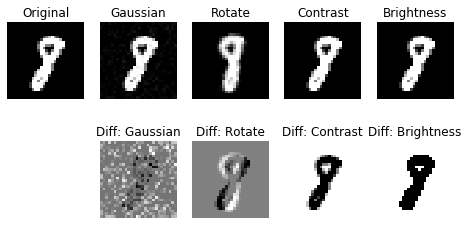

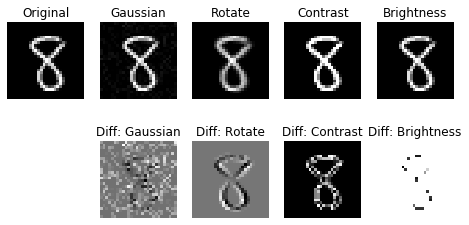

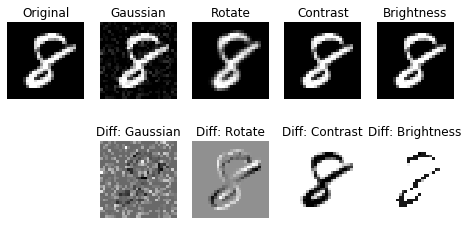

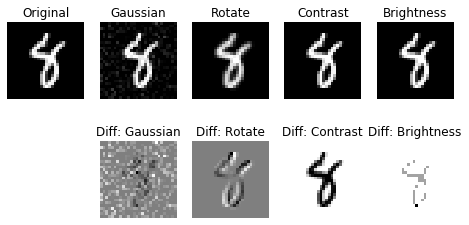

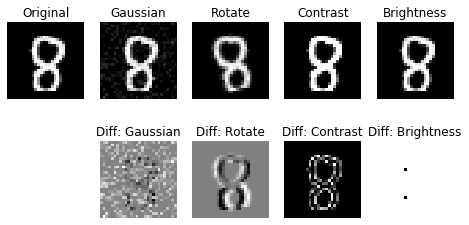

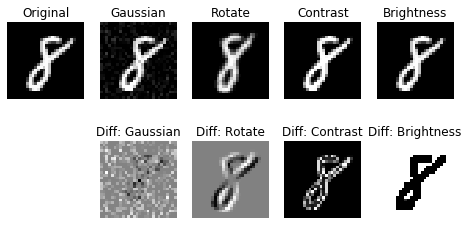

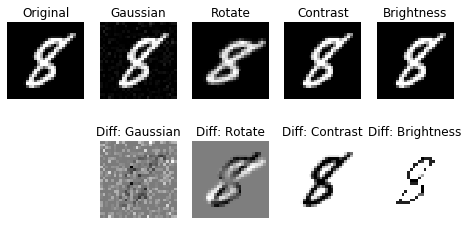

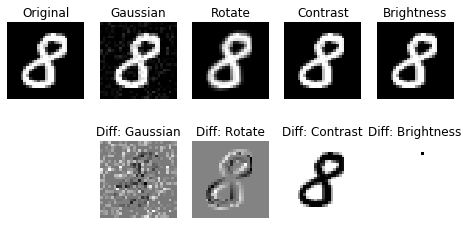

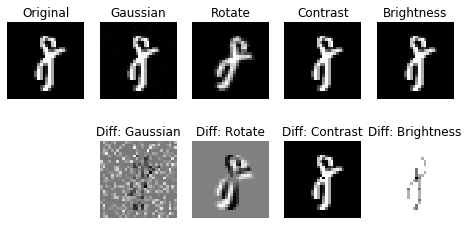

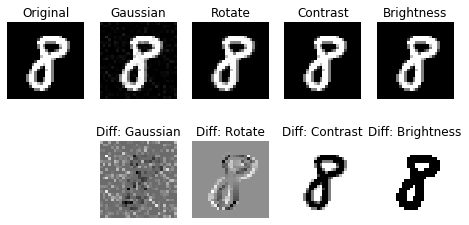

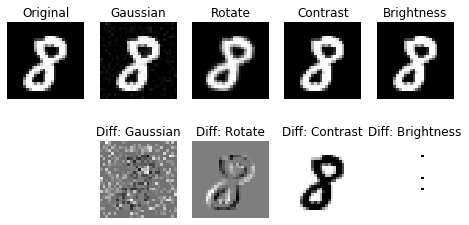

In [63]:
N = len(T)
demo_steps = 5
for i, (image, label) in enumerate(trainloader, 1):
    xt_list, label_list = [], ["Original", "Gaussian", "Rotate", "Contrast", "Brightness"]
    fig = plt.figure(figsize=(8, 4))
    ax = plt.subplot(2, N+1, 1)
    ax.set_title(label_list[0])
    plt.imshow(image[0][0].numpy(), cmap="gray")
    plt.axis("off")
    for t in T:
        xt_list.append(t(image))
    for c in range(2, N+2):
        ax = plt.subplot(2, N+1, c)
        ax.set_title(label_list[c-1])
        plt.imshow(xt_list[c-2][0][0].numpy(), cmap="gray")
        plt.axis("off")
        ax = plt.subplot(2, N+1, c+5)
        ax.set_title(f"Diff: {label_list[c-1]}")
        plt.imshow(xt_list[c-2][0][0].numpy() - image[0][0].numpy(), cmap="gray")
        plt.axis("off")
    plt.show()
    print("=======================================================")
    if i == 20:
        break

### Crafting and evalutaion function

In [49]:
# Universal pertubation crafting via EoT
def uni_eot_craft(model: nn.Module, T: list,
                  dataloader: DataLoader, epochs: int, step_size: float,
                  eps: float, device, clip_below=0., clip_above=1.,
                  criterion=None, verbose=True, log_interval=100):
    
    def _uni_craft_step(uni_pert):
        max_loss, average_loss, N = 0., 0., len(T)
        for i, (x, label) in enumerate(dataloader):
            x, label = x.to(device), label.to(device)
            for j, t in enumerate(T):
                uni_pert_nxt = Variable(uni_pert, requires_grad=True)
                x_adv = x + uni_pert_nxt
                x_adv = torch.clamp(x_adv, clip_below, clip_above)
                x_t = t(x_adv)
                logits = model(x_t)
                loss = criterion(logits, label)/N
                loss.backward()
                
                # Update the perturbation
                uni_pert = uni_pert + step_size*uni_pert_nxt.grad
                average_loss += loss.item()
                max_loss = max(max_loss, loss.item())
                
            uni_pert = torch.clamp(uni_pert, -eps, eps)
        average_loss /= (i+1)*N
        return uni_pert, average_loss, max_loss
    
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    uni_pert = torch.zeros((1, 1, 28, 28)).to(device)
    for epoch in range(1, epochs+1):
        uni_pert, average_loss, max_loss = _uni_craft_step(uni_pert)
        if verbose and epoch % log_interval == 0:
            plt.imshow(uni_pert.detach().cpu().numpy()[0][0], cmap="gray")
            plt.title(f"Epoch {epoch}: \n Average loss = {average_loss:.3f}; Max loss = {max_loss:.3f}")
            plt.axis("off")
            plt.show()
    return uni_pert

In [65]:
# Evaluation function
def uni_adv_eval(model, uni_pert, random_transform,
                 testloader, device, verbose=True):
    succ, total = 0, 0
    for i, (images, labels) in enumerate(testloader):
        images, labels = images.to(device), labels.to(device)
        total += images.size(0)
        x = torch.clamp(images+uni_pert, 0., 1.)
        x_t = random_transform(x)
        
        with torch.no_grad():
            logits = model(x_t)
        _, predicted = logits.max(1)
        succ += predicted.ne(labels).sum().item()
        
        if verbose and total % 100 == 0:
            x_np = x[0][0].cpu().numpy()
            xt_np = x_t[0][0].cpu().numpy()
            print(f"Success rate: {succ/total:.3f}")
            fig = plt.figure(figsize=(8, 4))
            ax = plt.subplot(131)
            ax.set_title('adv')
            plt.imshow(x_np, cmap="gray")
            plt.axis("off")
            ax = plt.subplot(132)
            ax.set_title('t(adv)')
            plt.imshow(x_t[0][0].cpu().numpy(), cmap="gray")
            plt.axis("off")
            ax = plt.subplot(133)
            ax.set_title("t(adv) - adv")
            plt.imshow(np.clip(xt_np - x_np, 0., 1.), cmap="gray")
            plt.axis("off")
            plt.show()
            
    succ_rate = succ/total
    return succ_rate

### Experiments

In [74]:
epochs = 50
step_size = 5e-3
eps = 76./255.
log_interval = 5
criterion = get_clipped_loss(nn.CrossEntropyLoss(), float("-inf"), 9.)

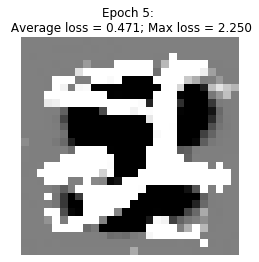

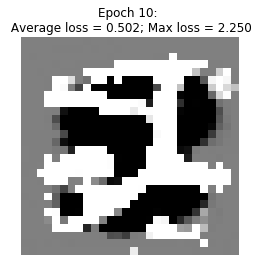

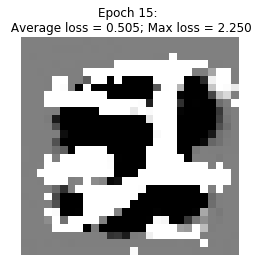

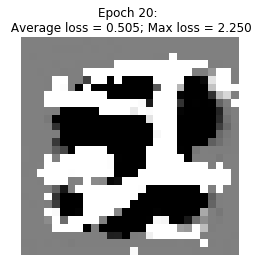

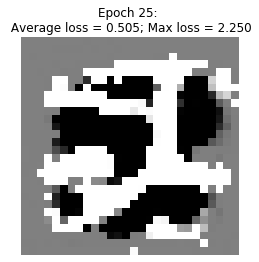

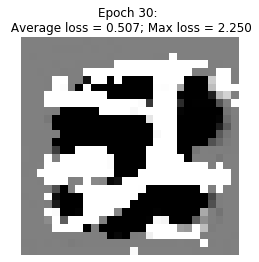

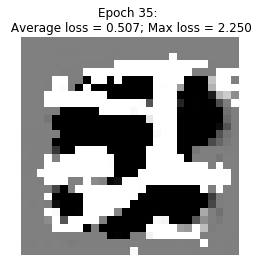

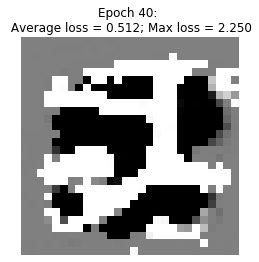

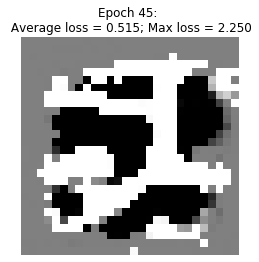

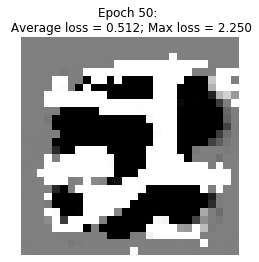

In [75]:
uni_pertub = uni_eot_craft(model, T, trainloader,
                           epochs, step_size, eps, device, criterion=criterion, log_interval=log_interval)

Success rate: 0.600


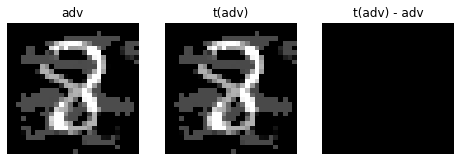

Success rate: 0.590


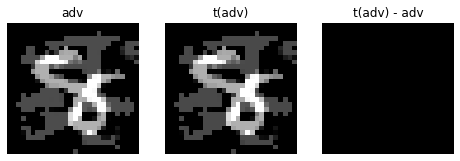

Success rate: 0.613


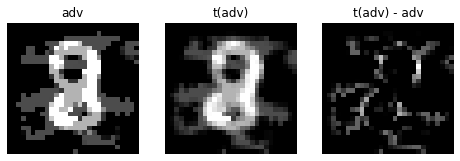

Success rate: 0.623


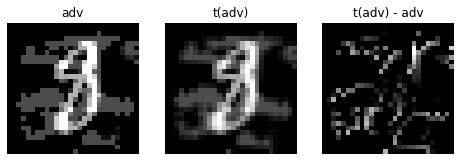

Success rate: 0.620


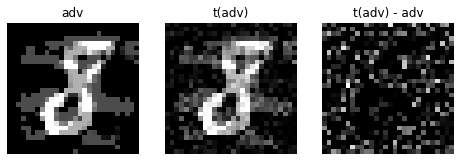

Success rate: 0.628


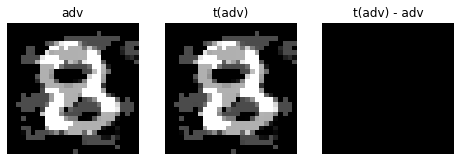

Success rate: 0.641


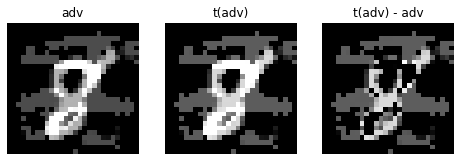

Success rate: 0.647


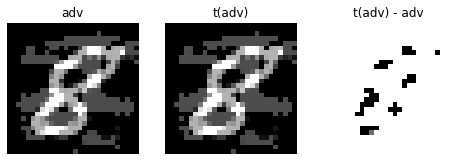

Success rate: 0.624


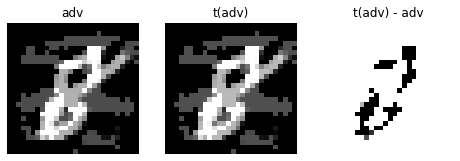

Success rate: 0.6252566735112937


In [76]:
succ_rate = uni_adv_eval(model, uni_pertub, random_transform, 
                         testloader, device)
print(f"Success rate: {succ_rate}")